<a name='top'></a><a id='top'></a>
# Chapter 11 – Training Deep Neural Networks

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

1. [Setup](#setup)
2. [Vanishing/Exploding Gradients Problem](#2.0)
    - [2.1 Glorot and He Initialization](#2.1)
        * [2.1.1 Glorot Initialization (Xavier Glorot & Yoshua Bengio)](#2.1.1)
        * [2.1.2 He Initialization](#2.1.2)
    - [2.2 Initializer comparison (extra material)](#2.2)
    - [2.3 Nonsaturating Activation Functions](#2.3)
        * [2.3.1 Leaky ReLU](#2.4.1)
        * [2.3.2 PReLU](#2.4.2)
        * [2.3.3 ELU](#2.4.3)
        * [2.3.4 SELU](#2.4.4)
        * [2.3.5 RELU](#2.4.5)
        * [2.3.6 Overall Test of Activation Functions](#2.4.6)
    - [2.4 Batch Normalization](#2.4)
    - [2.5 Gradient Clipping](#2.5)
        * [2.5.1 Gradient Clipping: Clip tensor values to a specified min and max](#2.5.1)
        * [2.5.2 Gradient Clipping: Clip tensor values to a maximum L2-norm](#2.5.2)
3. [Reusing Pretrained Layers](#3.0)
    - [3.1  Transfer Learning with Keras](#3.1)
    - [3.2  Unsupervised Pretraining](#3.2)
    - [3.3  Pretraining on an Auxiliary Task](#3.3)
4. [Faster Optimizers](#4.0)
    - [4.1 Momentum optimization](#4.1)
    - [4.2 Nesterov Accelerated Gradient / NAG](#4.2)
    - [4.3 AdaGrad](#4.3)
    - [4.4 RMSProp](#4.4)
    - [4.5 Adam Optimization](#4.5)
        * [4.5.1 Adamax Optimization](#4.5.1)
        * [4.5.2 Nadam Optimization](#4.5.2)
    - [4.6 Learning Rate Scheduling](#4.6)
        * [4.6.1 Power Scheduling](#4.6.1)
        * [4.6.2 Exponential Scheduling](#4.6.2)
            - [4.6.2.1 Exponential Scheduling - Standard](#4.6.2.1)
            - [4.6.2.2 Exponential Scheduling - Using current LR](#4.6.2.2)
            - [4.6.2.3 Exponential Scheduling - Update LR at each iteration](#4.6.2.3)
        * [4.6.3 Piecewise Constant Scheduling](#4.6.3)
        * [4.6.4 Performance Scheduling](#4.6.4)
        * [4.6.5 tf.keras Schedulers](#4.6.5)
            - [4.6.5.1 tf.keras scheduler using ExponentialDecay](#4.6.5.1)
            - [4.6.5.2 tf.keras scheduler using PiecewiseConstantDecay](#4.6.5.2)
        * [4.6.6 1Cycle scheduling](#4.6.6)
5. [Avoiding Overfitting Through Regularization](#5.0)
    - [5.1 ℓ1 and ℓ2 regularization](#5.1)
         * [5.1.1 ℓ1 and ℓ2 regularization using functools.partial()](#5.1.1)
    - [5.2 Dropout](#5.2)
        * [5.1.1 $\ell_1$ and $\ell_2$ regularization using functools.partial()](#5.1.1)
    - [5.3 Alpha Dropout](#5.3)
    - [5.4 Monte Carlo (MC) Dropout](#5.4)
        * [5.4.1 MC Dropout, Model with standard layers](#5.4.1)
        * [5.4.2 MC Dropout, Model with customized layers](#5.4.2)
    - [5.5 Max-Norm Regularization](#5.5)

    11章 深層ニューラルネットワークの訓練
        11.1　勾配消失／爆発問題
            11.1.1　Glorotと Heの初期値
            11.1.2　飽和しない活性化関数
            11.1.3　バッチ正規化
            11.1.4　勾配クリッピング

        11.2　事前学習済みの層の再利用
            11.2.1　Kerasによる転移学習
            11.2.2　教師なし事前学習
            11.2.3　関連タスクの事前学習

        11.3　オプティマイザの高速化
            11.3.1　モーメンタム最適化
            11.3.2　NAG
            11.3.3　AdaGrad
            11.3.4　RMSProp
            11.3.5　Adam、Nadam最適化
            11.3.6　学習率のスケジューリング

        11.4　正則化による過学習の防止
            11.4.1　ℓ1、ℓ2 正則化
            11.4.2　ドロップアウト
            11.4.3　モンテカルロ（MC）ドロップアウト
            11.4.4　重み上限正則化
        11.5　まとめと実践的なガイドライン
        11.6　演習問題
        
* [AI・機械学習の用語辞典](https://atmarkit.itmedia.co.jp/ait/subtop/features/di/mlglossary_index.html)

---
<a name='setup'></a><a id="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# for stable output across runs
tf.random.set_seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=4)

def HR():
    print("-"*40)

print("Finished imports")

Finished imports


In [2]:
DATA_ROOT = 'data_chp11'

---
<a id='2.0'></a><a name='2.0'></a>
# 2. Vanishing/Exploding Gradients Problem / 勾配消失／爆発問題
<a href="#top">[back to top]</a>

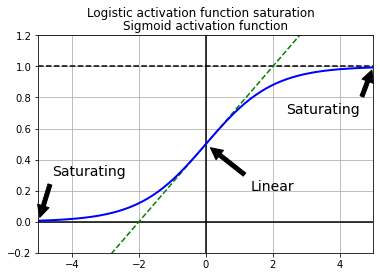

In [3]:
def listing2():
    import traceback
    
    def logit(z):
        return 1 / (1 + np.exp(-z))

    z = np.linspace(-5, 5, 200)

    plt.plot([-5, 5], [0, 0], 'k-')
    plt.plot([-5, 5], [1, 1], 'k--')
    plt.plot([0, 0], [-0.2, 1.2], 'k-')
    plt.plot([-5, 5], [-3/4, 7/4], 'g--')
    plt.plot(z, logit(z), "b-", linewidth=2)

    props = dict(facecolor='black', shrink=0.1)

    plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
    plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
    plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
    plt.grid(True)
    plt.title("Sigmoid activation function")
    plt.axis([-5, 5, -0.2, 1.2])
    plt.suptitle("Logistic activation function saturation")
    plt.show()

listing2()

<a id='2.1'></a><a name='2.1'></a>
## 2.1 Glorot and He Initialization
<a href="#top">[back to top]</a>

<a id='2.1.1'></a><a name='2.1_1'></a>
### 2.1.1 Glorot Initialization (Xavier Glorot & Yoshua Bengio)
<a href="#top">[back to top]</a>

Activation functions for Glorot initialization: None, tanh, logistics, softmax

https://keras.io/api/layers/initializers/

In [4]:
# Keras default glorot_uniform initialization
def listing2_1_1():
    
    layer_none = keras.layers.Dense(10, activation=None, kernel_initializer="glorot_uniform")
    pp.pprint(layer_none.get_config())
    HR()
    
    layer_tanh = keras.layers.Dense(10, activation="tanh", kernel_initializer="glorot_uniform")
    pp.pprint(layer_tanh.get_config())
    HR()

    # Assume `logistic` refers to the `sigmoid` function
    layer_logistic = keras.layers.Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform")
    pp.pprint(layer_logistic.get_config())
    HR()    

    layer_softmax = keras.layers.Dense(10, activation="softmax", kernel_initializer="glorot_uniform")
    pp.pprint(layer_softmax.get_config())
    
listing2_1_1()

{   'activation': 'linear',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {   'class_name': 'GlorotUniform',
                              'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense',
    'trainable': True,
    'units': 10,
    'use_bias': True}
----------------------------------------
{   'activation': 'tanh',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {   'class_name': 'GlorotUniform',
                              'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense_1',
    'trainable': True,
    'units': 10,
    'use_bias': True}
---------------

<a id='2.1.2'></a><a name='2.1_2'></a>
### 2.1.2 He Initialization
<a href="#top">[back to top]</a>

Activation functions for He initialization: ReLU and variants

https://keras.io/api/layers/initializers/

In [5]:
# Use He initialization
def listing2_1_2():
    
    layer_he_uniform = keras.layers.Dense(10, activation="relu", kernel_initializer="he_uniform")
    pp.pprint(layer_he_uniform.get_config())
    HR()
    
    layer_he_normal = keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
    pp.pprint(layer_he_normal.get_config())    
    HR()

    # He initialization with uniform distribution based on fan_avg
    init = keras.initializers.VarianceScaling(
        scale=2., 
        mode='fan_avg',
        distribution='uniform'
    )
    layer_fan_avg = keras.layers.Dense(10, activation="relu", kernel_initializer=init)
    pp.pprint(layer_fan_avg.get_config())
    
listing2_1_2()

{   'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'HeUniform', 'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense_4',
    'trainable': True,
    'units': 10,
    'use_bias': True}
----------------------------------------
{   'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense_5',
    'trainable': True,
    'units': 10,
    'use_bias': True}
----------------------------------------
{   'activation': 'relu',
    'activity_regulariz

<a id='2.2'></a><a name='2.2'></a>
## 2.2 Initializer comparison (extra material)
<a href="#top">[back to top]</a>

**To-do**:

Fix this code.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


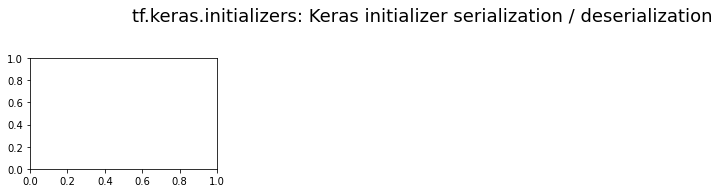

In [6]:
def listing2_2():
    import pandas as pd
    import traceback
    
    data_list = [name for name in dir(tf.keras.initializers) if not name.startswith("_")]
    data_length = len(data_list)
    #print(data_length)
    
    columns = 4
    
    # Keep column width constant, need to calculate row-length
    rows = int(data_length / columns)+1        
    plt_row_size = (rows*2)
    
    # width, height
    fig = plt.figure(figsize=(12,plt_row_size))
    i = 1
    
    for x in data_list:
        
        try:
            init_func = f"tf.keras.initializers.{x}()"
            initializer = eval(init_func)
            values = initializer(shape=(200, 1))
            df = pd.DataFrame(values)
            ax = fig.add_subplot(rows, columns,i) # i must not be 0, else cause matplotlib error
            df.plot(ax=ax, kind="hist", title=x, legend=False, grid=True)
            i+=1
                        
        except Exception as e:
            pass
    
    plt.suptitle("tf.keras.initializers: Keras initializer serialization / deserialization", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94) # Call after tight_layout()
    plt.show()

listing2_2()

<a id='2.3'></a><a name='2.3'></a>
## 2.3 Nonsaturating Activation Functions / 飽和しない活性化関数
<a href="#top">[back to top]</a>

<a id='2.3.1'></a><a name='2.3.1'></a>
### 2.3.1 Leaky ReLU

用語「Leaky ReLU（Leaky Rectified Linear Unit）／LReLU」について説明。「0」を基点として、入力値が0より下なら「入力値とα倍した値」（α倍は基本的に0.01倍）、0以上なら「入力値と同じ値」を返す、ニューラルネットワークの活性化関数を指す。ReLUの拡張版。
* https://atmarkit.itmedia.co.jp/ait/articles/2005/13/news009.html

<a href="#top">[back to top]</a>

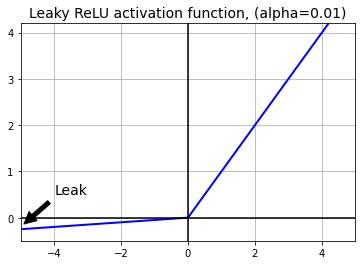

In [7]:
def listing2_3_1():
    
    # Hyperparameter α defines how much the function “leaks”
    def leaky_relu(z, alpha=0.01):
        return np.maximum(alpha*z, z)
        
    z = np.linspace(-5, 5, 200)
    
    plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
    plt.plot([-5, 5], [0, 0], 'k-')
    plt.plot([0, 0], [-0.5, 4.2], 'k-')
    plt.grid(True)
    props = dict(facecolor='black', shrink=0.1)
    
    plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
    plt.title("Leaky ReLU activation function, (alpha=0.01)", fontsize=14)
    plt.axis([-5, 5, -0.5, 4.2])

    plt.show()
    
listing2_3_1()

In [8]:
def listing2_3_1_extra():

    data = [m for m in dir(keras.activations) if not m.startswith("_")]
    pp.pprint(data)
    HR()
    
    data2 = [m for m in dir(keras.layers) if "relu" in m.lower()]
    pp.pprint(data2)
    HR()
    
listing2_3_1_extra()

[   'deserialize',
    'elu',
    'exponential',
    'gelu',
    'get',
    'hard_sigmoid',
    'linear',
    'relu',
    'selu',
    'serialize',
    'sigmoid',
    'softmax',
    'softplus',
    'softsign',
    'swish',
    'tanh']
----------------------------------------
['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']
----------------------------------------


In [9]:
# Data: Fashion MNIST
# Model: MLP with keras.layers.LeakyReLU

def listing2_3_1_model():
    
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(model.summary())
    
listing2_3_1_model()

Epoch 1/5
1719/1719 - 7s - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160 - 7s/epoch - 4ms/step
Epoch 2/5
1719/1719 - 7s - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658 - 7s/epoch - 4ms/step
Epoch 3/5
1719/1719 - 7s - loss: 0.6816 - accuracy: 0.7720 - val_loss: 0.6427 - val_accuracy: 0.7898 - 7s/epoch - 4ms/step
Epoch 4/5
1719/1719 - 5s - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064 - 5s/epoch - 3ms/step
Epoch 5/5
1719/1719 - 4s - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8202 - 4s/epoch - 2ms/step
----------------------------------------
157/157 - 0s - loss: 0.5582 - accuracy: 0.8202 - 469ms/epoch - 3ms/step
[test loss, test accuracy]: [0.5581830739974976, 0.8202000260353088]
----------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (

Layer: 0: mean: 0.39, std deviation: 0.59
Layer: 2: mean: 0.19, std deviation: 0.20
Layer: 4: mean: 0.08, std deviation: 0.08
Layer: 6: mean: 0.04, std deviation: 0.03
Layer: 8: mean: 0.02, std deviation: 0.01
Layer: 10: mean: 0.01, std deviation: 0.01
Layer: 12: mean: 0.00, std deviation: 0.00
Layer: 14: mean: 0.00, std deviation: 0.00
Layer: 16: mean: 0.00, std deviation: 0.00
Layer: 18: mean: 0.00, std deviation: 0.00
Layer: 20: mean: 0.00, std deviation: 0.00
Layer: 22: mean: 0.00, std deviation: 0.00
Layer: 24: mean: 0.00, std deviation: 0.00
Layer: 26: mean: 0.00, std deviation: 0.00
Layer: 28: mean: 0.00, std deviation: 0.00
Layer: 30: mean: 0.00, std deviation: 0.00
Layer: 32: mean: 0.00, std deviation: 0.00
Layer: 34: mean: 0.00, std deviation: 0.00
Layer: 36: mean: 0.00, std deviation: 0.00
Layer: 38: mean: 0.00, std deviation: 0.00


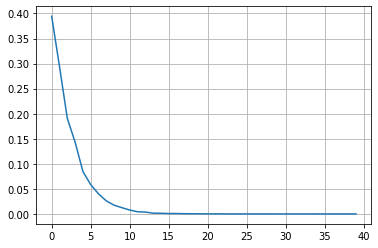

In [10]:
# Test of leaky_relu
def listing2_2_5_test():
    from scipy.special import erfc
    
    np.random.seed(42)
    
    # alpha and scale to self normalize with mean 0 and standard deviation 1 (see equation 14 in the paper):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
        
    # Built-in relu functions: NOT WORKING
    # def leaky_relu(z):
    #     return tf.nn.leaky_relu(z)

    def leaky_relu(z, alpha=0.01):
        return np.maximum(alpha*z, z)

    data_means = []
    Z = np.random.normal(size=(500, 100)) # standardized inputs
    for layer in range(40):
        W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
        Z = leaky_relu(np.dot(Z, W))
        means = np.mean(Z, axis=0).mean()
        stds = np.std(Z, axis=0).mean()
        if layer % 2 == 0:
            print(f"Layer: {layer}: mean: {means:.2f}, std deviation: {stds:.2f}")
        data_means.append(means)
 
    import pandas as pd
    df = pd.DataFrame(data_means)
    df.plot(grid=True, legend=False)
    plt.show()
    
listing2_2_5_test()

<a id='2.3.2'></a><a name='2.3.2'></a>
### 2.3.2 PReLU

用語「PReLU（Parametric ReLU）」について説明。「0」を基点として、入力値が0より下なら「入力値をα倍した値」（αはパラメーターであり学習により決まる）、0以上なら「入力値と同じ値」を返す、ニューラルネットワークの活性化関数を指す。ReLUやLeaky ReLUの拡張版

* https://atmarkit.itmedia.co.jp/ait/articles/2005/20/news010.html

<a href="#top">[back to top]</a>

In [11]:
# Data: Fashion MNIST
# Model: MLP with keras.layers.PReLU

def listing2_3_2():
    
    tf.random.set_seed(42)

    # Get dataset
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(model.summary())
    
listing2_3_2()

Epoch 1/5
1719/1719 - 7s - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186 - 7s/epoch - 4ms/step
Epoch 2/5
1719/1719 - 5s - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630 - 5s/epoch - 3ms/step
Epoch 3/5
1719/1719 - 4s - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878 - 4s/epoch - 3ms/step
Epoch 4/5
1719/1719 - 6s - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046 - 6s/epoch - 3ms/step
Epoch 5/5
1719/1719 - 4s - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5657 - val_accuracy: 0.8178 - 4s/epoch - 2ms/step
----------------------------------------
157/157 - 0s - loss: 0.5657 - accuracy: 0.8178 - 304ms/epoch - 2ms/step
[test loss, test accuracy]: [0.5656538605690002, 0.817799985408783]
----------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_

<a id='2.3.3'></a><a name='2.3.3'></a>
### 2.3.3 ELU

用語「ELU（Exponential Linear Unit）」について説明。「0」を基点として、入力値が0以下なら「0」～「-α」（αは基本的に1.0）の間の値を、0より上なら「入力値と同じ値」を返す、ニューラルネットワークの活性化関数を指す。ReLUの拡張版。

* https://atmarkit.itmedia.co.jp/ait/articles/2005/27/news015.html
* https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#elu

A 2015 paper by Djork-Arné Clevert et al.6 proposed a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.

The ELU activation function looks a lot like the ReLU function, with a few major differences:

* It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
* It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
* If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0.


<a href="#top">[back to top]</a>

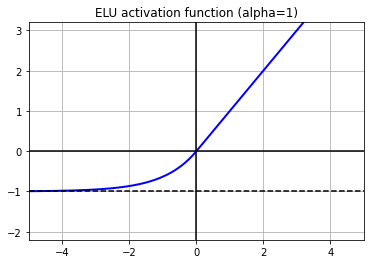

In [12]:
def listing2_3_3_graph():
    
    def elu(z, alpha=1):
        return tf.nn.elu(z)
    
    z = np.linspace(-5, 5, 200)

    plt.plot(z, elu(z), "b-", linewidth=2)
    plt.plot([-5, 5], [0, 0], 'k-')
    plt.plot([-5, 5], [-1, -1], 'k--') # dark horizonal line
    plt.plot([0, 0], [-2.2, 3.2], 'k-') # dark vert line
    plt.grid(True)
    plt.title(r"ELU activation function (alpha=1)")
    plt.axis([-5, 5, -2.2, 3.2])
    plt.show()
    
listing2_3_3_graph()

Layer: 0: mean: 0.16, std deviation: 0.79
Layer: 1: mean: 0.12, std deviation: 0.63
Layer: 2: mean: 0.07, std deviation: 0.52
Layer: 3: mean: 0.06, std deviation: 0.44
Layer: 4: mean: 0.04, std deviation: 0.39
Layer: 5: mean: 0.04, std deviation: 0.34
Layer: 6: mean: 0.02, std deviation: 0.30
Layer: 7: mean: 0.03, std deviation: 0.28
Layer: 8: mean: 0.01, std deviation: 0.25
Layer: 9: mean: 0.02, std deviation: 0.23
Layer: 10: mean: 0.01, std deviation: 0.20
Layer: 11: mean: 0.01, std deviation: 0.19
Layer: 12: mean: 0.01, std deviation: 0.18
Layer: 13: mean: 0.00, std deviation: 0.17
Layer: 14: mean: 0.01, std deviation: 0.16
Layer: 15: mean: 0.01, std deviation: 0.14
Layer: 16: mean: 0.01, std deviation: 0.13
Layer: 17: mean: 0.01, std deviation: 0.13
Layer: 18: mean: 0.01, std deviation: 0.12
Layer: 19: mean: -0.00, std deviation: 0.11
Layer: 20: mean: -0.00, std deviation: 0.11
Layer: 21: mean: 0.01, std deviation: 0.10
Layer: 22: mean: 0.01, std deviation: 0.09
Layer: 23: mean: 0.

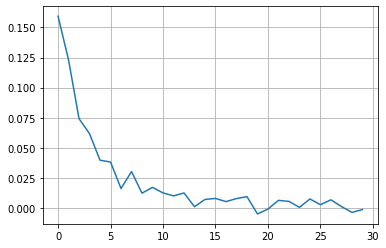

In [13]:
def listing2_3_3_test():
    from scipy.special import erfc
    
    np.random.seed(42)
    
    # alpha and scale to self normalize with mean 0 and standard deviation 1
    # (see equation 14 in the paper):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
    
    def elu(z, alpha=1):
        return np.where(z < 0, alpha * (np.exp(z) - 1), z)
    
    # def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    #     return scale * elu(z, alpha)

    # THESE ARE NOT WORKING
    # Built-in selu and elu functions
#     def selu(z, alpha=1):
#         return tf.nn.selu(z)
    
#     def elu(z, alpha=1):
#         return tf.nn.elu(z)
    
    data_means = []
    Z = np.random.normal(size=(500, 100)) # standardized inputs
    for layer in range(30):
        W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
        Z = elu(np.dot(Z, W))
        means = np.mean(Z, axis=0).mean()
        stds = np.std(Z, axis=0).mean()
        #if layer % 100 == 0:
        print(f"Layer: {layer}: mean: {means:.2f}, std deviation: {stds:.2f}")
        data_means.append(means)
 
    import pandas as pd
    df = pd.DataFrame(data_means)
    df.plot(grid=True, legend=False)
    plt.show()
    
listing2_3_3_test()

In [14]:
# Data: Fashion MNIST
# Model: MLP with keras.layers.PReLU, elu-activation

def listing2_3_3():

    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal", activation="elu"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal", activation="elu"),
        keras.layers.PReLU(),
        keras.layers.Dense(10, activation="softmax") # elu or softmax?
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(model.summary())
    
listing2_3_3()

Epoch 1/5
1719/1719 - 5s - loss: 1.3465 - accuracy: 0.6208 - val_loss: 0.9257 - val_accuracy: 0.7190 - 5s/epoch - 3ms/step
Epoch 2/5
1719/1719 - 5s - loss: 0.8198 - accuracy: 0.7356 - val_loss: 0.7306 - val_accuracy: 0.7628 - 5s/epoch - 3ms/step
Epoch 3/5
1719/1719 - 5s - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7876 - 5s/epoch - 3ms/step
Epoch 4/5
1719/1719 - 6s - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.6003 - val_accuracy: 0.8046 - 6s/epoch - 3ms/step
Epoch 5/5
1719/1719 - 4s - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8182 - 4s/epoch - 3ms/step
----------------------------------------
157/157 - 0s - loss: 0.5656 - accuracy: 0.8182 - 344ms/epoch - 2ms/step
[test loss, test accuracy]: [0.5655964016914368, 0.8181999921798706]
----------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten

<a id='2.3.4'></a><a name='2.3.4'></a>
### 2.3.4 SELU

<a href="#top">[back to top]</a>

用語「SELU（Scaled Exponential Linear Unit）」について説明。「0」を基点として、入力値が0以下なら「0」～「-λα」（λは基本的に約1.0507、αは基本的に約1.6733）の間の値を、0より上なら「入力値をλ倍した値」を返す、ニューラルネットワークの活性化関数を指す。ReLUおよびELUの拡張版。

* https://atmarkit.itmedia.co.jp/ait/articles/2006/03/news019.html

---

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

---

SELU is is a scaled variant of the ELU activation function.

A 2017 paper by Günter Klambauer et al. introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

* The input features must be standardized (mean 0 and standard deviation 1).
* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal`.
* The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
* The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well (see Chapter 14).

---

So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general:

    SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. 

If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). 

If you care a lot about runtime latency, then you may prefer leaky ReLU. 

If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU). 

If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set. 

That said, because ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

---

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem.



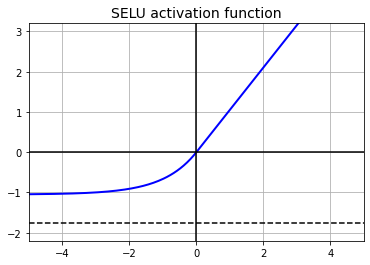

In [15]:
def listing2_3_4_graph():
    
    from scipy.special import erfc

    # alpha and scale to self normalize with mean 0 and standard deviation 1
    # (see equation 14 in the paper):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
    
    def elu(z, alpha=1):
        return tf.nn.elu(z)
    
    z = np.linspace(-5, 5, 200)
    
    def selu(z, scale=scale_0_1, alpha=alpha_0_1):
        return scale * elu(z, alpha)
    
    plt.plot(z, selu(z), "b-", linewidth=2)
    plt.plot([-5, 5], [0, 0], 'k-')
    plt.plot([-5, 5], [-1.758, -1.758], 'k--')
    plt.plot([0, 0], [-2.2, 3.2], 'k-')
    plt.grid(True)
    plt.title("SELU activation function", fontsize=14)
    plt.axis([-5, 5, -2.2, 3.2])

    plt.show()
    
listing2_3_4_graph()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). 

Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [16]:
# Data: Fashion MNIST
# Model: MLP with 100 hidden layers, SELU activation function

def listing2_3_4():

    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    # Scale the inputs to mean 0 and standard deviation 1.
    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))

    for layer in range(99):
        model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )

    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
        
    history = model.fit(
        X_train_scaled, y_train, 
        epochs=5,
        validation_data=(X_valid_scaled, y_valid),
        verbose=2
    )  

    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)    

    HR()
    
    print(model.summary())
    
listing2_3_4()

Epoch 1/5
1719/1719 - 26s - loss: 1.2933 - accuracy: 0.5122 - val_loss: 1.1249 - val_accuracy: 0.5768 - 26s/epoch - 15ms/step
Epoch 2/5
1719/1719 - 18s - loss: 0.8387 - accuracy: 0.6819 - val_loss: 0.7307 - val_accuracy: 0.7362 - 18s/epoch - 10ms/step
Epoch 3/5
1719/1719 - 17s - loss: 0.7145 - accuracy: 0.7345 - val_loss: 0.8415 - val_accuracy: 0.6598 - 17s/epoch - 10ms/step
Epoch 4/5
1719/1719 - 18s - loss: 0.6880 - accuracy: 0.7506 - val_loss: 0.6032 - val_accuracy: 0.7754 - 18s/epoch - 10ms/step
Epoch 5/5
1719/1719 - 17s - loss: 0.7500 - accuracy: 0.7309 - val_loss: 0.7105 - val_accuracy: 0.7652 - 17s/epoch - 10ms/step
----------------------------------------
157/157 - 1s - loss: 1.5405 - accuracy: 0.4932 - 1s/epoch - 7ms/step
[test loss, test accuracy]: [1.5404752492904663, 0.49320000410079956]
----------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param 

<a id='2.3.5'></a><a name='2.3.5'></a>
### 2.3.5 RELU

用語「ReLU（Rectified Linear Unit）／ランプ関数」について説明。「0」を基点として、0以下なら「0」、0より上なら「入力値と同じ値」を返す、ニューラルネットワークの活性化関数を指す。

* https://atmarkit.itmedia.co.jp/ait/articles/2003/11/news016.html

<a href="#top">[back to top]</a>

In [17]:
# Data: Fashion MNIST
# Model: MLP with 100 hidden layers, RELU activation function
# This should perform worse than SELU, since it suffers from the vanishing/exploding gradients problem.

def listing2_3_5():
    
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    # Scale the inputs to mean 0 and standard deviation 1.
    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))

    for layer in range(99):
        model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))

    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=1e-3),
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=5,
        validation_data=(X_valid_scaled, y_valid),
        verbose=2
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(model.summary())    

listing2_3_5()

Epoch 1/5
1719/1719 - 23s - loss: 1.8095 - accuracy: 0.2688 - val_loss: 1.4305 - val_accuracy: 0.3600 - 23s/epoch - 13ms/step
Epoch 2/5
1719/1719 - 18s - loss: 1.1348 - accuracy: 0.5196 - val_loss: 0.9388 - val_accuracy: 0.6292 - 18s/epoch - 10ms/step
Epoch 3/5
1719/1719 - 20s - loss: 0.9248 - accuracy: 0.6242 - val_loss: 0.8201 - val_accuracy: 0.6810 - 20s/epoch - 11ms/step
Epoch 4/5
1719/1719 - 17s - loss: 0.8170 - accuracy: 0.6777 - val_loss: 0.7776 - val_accuracy: 0.6996 - 17s/epoch - 10ms/step
Epoch 5/5
1719/1719 - 17s - loss: 0.8745 - accuracy: 0.6497 - val_loss: 0.8889 - val_accuracy: 0.6558 - 17s/epoch - 10ms/step
----------------------------------------
157/157 - 1s - loss: 4.0805 - accuracy: 0.1690 - 816ms/epoch - 5ms/step
[test loss, test accuracy]: [4.080451965332031, 0.16899999976158142]
----------------------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Para

Layer: 0: mean: 0.40, std deviation: 0.58
Layer: 1: mean: 0.30, std deviation: 0.35
Layer: 2: mean: 0.19, std deviation: 0.20
Layer: 3: mean: 0.14, std deviation: 0.13
Layer: 4: mean: 0.09, std deviation: 0.08
Layer: 5: mean: 0.06, std deviation: 0.05
Layer: 6: mean: 0.04, std deviation: 0.03
Layer: 7: mean: 0.03, std deviation: 0.02
Layer: 8: mean: 0.02, std deviation: 0.01
Layer: 9: mean: 0.01, std deviation: 0.01
Layer: 10: mean: 0.01, std deviation: 0.00
Layer: 11: mean: 0.00, std deviation: 0.00
Layer: 12: mean: 0.00, std deviation: 0.00
Layer: 13: mean: 0.00, std deviation: 0.00
Layer: 14: mean: 0.00, std deviation: 0.00
Layer: 15: mean: 0.00, std deviation: 0.00
Layer: 16: mean: 0.00, std deviation: 0.00
Layer: 17: mean: 0.00, std deviation: 0.00
Layer: 18: mean: 0.00, std deviation: 0.00
Layer: 19: mean: 0.00, std deviation: 0.00


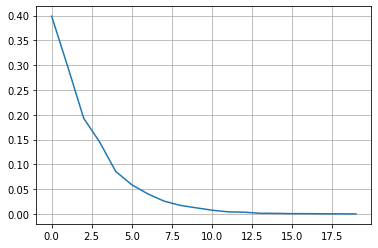

In [18]:
# This illustrates the dying ReLUs, where in training some neurons stop outputting anything other than 0.
def listing2_3_5_extra():
    from scipy.special import erfc
    import pandas as pd

    np.random.seed(42)

    # alpha and scale to self normalize with mean 0 and standard deviation 1 (see equation 14 in the paper):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
        
    # Built-in relu functions
    # def relu(z):
    #     return tf.nn.relu(z)
    
    def relu(z, alpha=1):
        return np.where(z > 0, z, 0)

    data_means = []
    Z = np.random.normal(size=(500, 100)) # standardized inputs
    #for layer in range(1000):
    for layer in range(20):
        W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
        Z = relu(np.dot(Z, W))
        means = np.mean(Z, axis=0).mean()
        stds = np.std(Z, axis=0).mean()
        
        # Print every iteration to show how quickly ReLU dies here:
        print(f"Layer: {layer}: mean: {means:.2f}, std deviation: {stds:.2f}")
        data_means.append(means)
 
    df = pd.DataFrame(data_means)
    df.plot(grid=True, legend=False)
    plt.show()
    
listing2_3_5_extra()

<a id='2.3.6'></a><a name='2.3.6'></a>
### 2.3.6 Overall Test of Activation Functions (added)
<a href="#top">[back to top]</a>

Sigmoid
Layer: 0: mean: 0.499, std deviation: 0.208
Layer: 2: mean: 0.496, std deviation: 0.011
Layer: 4: mean: 0.491, std deviation: 0.001
Layer: 6: mean: 0.506, std deviation: 0.000
Layer: 8: mean: 0.503, std deviation: 0.000
Layer: 10: mean: 0.499, std deviation: 0.000
Layer: 12: mean: 0.515, std deviation: 0.000
Layer: 14: mean: 0.508, std deviation: 0.000
Layer: 16: mean: 0.507, std deviation: 0.000
Layer: 18: mean: 0.502, std deviation: 0.000
Layer: 20: mean: 0.494, std deviation: 0.000
Layer: 22: mean: 0.505, std deviation: 0.000
Layer: 24: mean: 0.501, std deviation: 0.000
Layer: 26: mean: 0.474, std deviation: 0.000
Layer: 28: mean: 0.485, std deviation: 0.000
----------------------------------------
SELU
Layer: 0: mean: -0.006, std deviation: 0.995
Layer: 2: mean: 0.005, std deviation: 0.984
Layer: 4: mean: -0.004, std deviation: 0.972
Layer: 6: mean: -0.009, std deviation: 0.964
Layer: 8: mean: -0.000, std deviation: 0.978
Layer: 10: mean: -0.003, std deviation: 0.965
Layer:

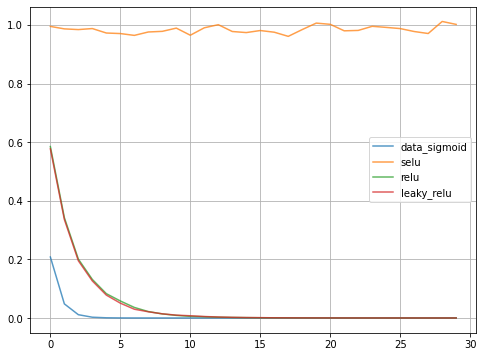

In [19]:
def listing_activation_functions():
    import pandas as pd
    from scipy.special import erfc

    np.random.seed(42)
    
    # alpha and scale to self normalize with mean 0 and standard deviation 1 (see equation 14 in the paper):
    alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
    scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
    
    def logit(z):
        return 1 / (1 + np.exp(-z))

    def elu(z, alpha=1):
        return np.where(z < 0, alpha * (np.exp(z) - 1), z)
        
    def selu(z, scale=scale_0_1, alpha=alpha_0_1):
        return scale * elu(z, alpha)

    def leaky_relu(z, alpha=0.01):
        return np.maximum(alpha*z, z)
    
    # def relu(z, alpha=0.01):
    #     return np.where(z > 0, z, 0)
    
    # equivalent to  np.where(x1 >= x2, x1, x2) when neither x1 nor x2 are nans,
    def relu(z):
        return(np.maximum(0, z)) 
    
    Z = np.random.normal(size=(500, 100)) # standardized inputs
    
    def run_layer(activation_fn, Z):
        #data_means = []
        data_stds = []
        
        for layer in range(30): # 1000
            W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization

            # Make this a parameter
            Z = activation_fn(np.dot(Z, W))

            means = np.mean(Z, axis=0).mean()
            stds = np.std(Z, axis=0).mean()
            if layer % 2 == 0:
                print(f"Layer: {layer}: mean: {means:.3f}, std deviation: {stds:.3f}")
            #data_means.append(means)
            data_stds.append(stds)
        HR()
        return data_stds

    print("Sigmoid")
    data_sigmoid = run_layer(logit, Z)
    
    print("SELU")
    data_selu = run_layer(selu, Z)
    
    print("RELU")
    data_relu = run_layer(relu, Z)
    
    print("Leaky RELU")
    data_leaky_relu = run_layer(leaky_relu, Z)
    

    df = pd.DataFrame(
        list(zip(data_sigmoid, data_selu, data_relu, data_leaky_relu)), 
        columns =['data_sigmoid', 'selu', 'relu', 'leaky_relu']
    )
    
    print(df.head(20))
    df.plot(grid=True, legend=True, alpha=0.75, figsize=(8,6))
    plt.show()
    
listing_activation_functions()

---
<a id='2.4'></a><a name='2.4'></a>
## 2.4. Batch Normalization / バッチ正規化

バッチ正規化(Batch Normalization) は，主に畳み込みニューラルネットワーク(CNN)の隠れ層において，ミニバッチ内のデータ分布をもとに，各チャンネルごとに，特徴を正規化したのち，スケール・シフトを行う微分可能な変換(層)である [Ioffe and Szegedy, 2015]．バッチ正規化は，元のCNNの表現力の高さを保ちつつも，学習の収束の高速化と安定化を達成できるので，層の深いモデルを安定して学習するために必須の技術である．

* https://cvml-expertguide.net/terms/dl/layers/batch-normalization-layer/

During training, BN standardizes its inputs, then rescales and offsets them.

<a href="#top">[back to top]</a>

In [20]:
def listing2_4():

    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    HR()
        
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ])

    bn1 = model.layers[1]
    print([(var.name, var.trainable) for var in bn1.variables])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, 
        y_train, 
        epochs=3,
        validation_data=(X_valid, y_valid),
        verbose=2
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(model.summary())  
    
listing2_4()

----------------------------------------
[('batch_normalization/gamma:0', True), ('batch_normalization/beta:0', True), ('batch_normalization/moving_mean:0', False), ('batch_normalization/moving_variance:0', False)]
Epoch 1/3
1719/1719 - 7s - loss: 0.8558 - accuracy: 0.7167 - val_loss: 0.5625 - val_accuracy: 0.8152 - 7s/epoch - 4ms/step
Epoch 2/3
1719/1719 - 7s - loss: 0.5782 - accuracy: 0.8041 - val_loss: 0.4834 - val_accuracy: 0.8388 - 7s/epoch - 4ms/step
Epoch 3/3
1719/1719 - 6s - loss: 0.5225 - accuracy: 0.8209 - val_loss: 0.4465 - val_accuracy: 0.8498 - 6s/epoch - 4ms/step
----------------------------------------
157/157 - 1s - loss: 0.4465 - accuracy: 0.8498 - 800ms/epoch - 5ms/step
[test loss, test accuracy]: [0.4465329945087433, 0.8497999906539917]
----------------------------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784

---
Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [21]:
def listing2_4b():
    
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    HR()
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(100, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
    print(model.summary())

    HR()
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    print("[test loss, test accuracy]:", eval_result)
    
listing2_4b()

----------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_221 (Dense)           (None, 300)               235200    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_222 (D

<a id='2.5'></a><a name='2.5'></a>
## 2.5 Gradient Clipping

* https://www.tensorflow.org/api_docs/python/tf/clip_by_norm
* https://www.tensorflow.org/api_docs/python/tf/clip_by_global_norm
* https://www.tensorflow.org/api_docs/python/tf/clip_by_value

<a href="#top">[back to top]</a>

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold.

This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. For other types of networks, Batch Normalization is usually sufficient.

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [22]:
# Clips tensor values to a specified min and max.
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [23]:
# Clips tensor values to a maximum L2-norm.
optimizer = keras.optimizers.SGD(clipnorm=1.0)

<a id='2.5.1'></a><a name='2.5.1'></a>
### 2.5.1 Gradient Clipping: Clip tensor values to a specified min and max
<a href="#top">[back to top]</a>

In [24]:
# Data: Fashion MNIST
# Model: MLP with Gradient Clipping

def listing2_5_1():
    
    # Only tensorflow random seed has an influence on the random choice of weights.
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        # This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0
        # This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. 
        optimizer=keras.optimizers.SGD(clipvalue=1.0),
        metrics=["accuracy"]
    )

    print(model.summary())
    HR()
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )

    print("[test loss, test accuracy]:", eval_result)
    
listing2_5_1()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 10)                3010      
                                                                 
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------
Epoch 1/5
1719/1719 - 4s - loss: 0.7451 - accuracy: 0.7603 - val_loss: 0.5415 - val_accuracy: 0.8276 - 4s/epoch - 2ms/step
Epoch 2/5
1719/1719 - 4s - loss: 0.5165 - accuracy: 0.8249 - val_loss: 0.4689 - val_accuracy: 0.8456 - 4s/epoch - 2ms/step
Epoch 3/5
1719/1719 

<a id='2.5.2'></a><a name='2.5.2'></a>
### 2.5.2 Gradient Clipping: Clip tensor values to a maximum L2-norm
<a href="#top">[back to top]</a>

If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm`. This will clip the whole gradient if its l2 norm is greater than the threshold you picked.

For example, if you set `clipnorm=1.0`, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.

In [25]:
# Data: Fashion MNIST
# Model: MLP with Gradient Clipping

def listing2_5_2():
    
    # Only tensorflow random seed has an influence on the random choice of weights.
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        # The gradient of each weight is individually clipped so that its norm is no higher than this value.
        optimizer=keras.optimizers.SGD(clipnorm=1.0),
        metrics=["accuracy"]
    )

    print(model.summary())

    HR()
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=5,
        validation_data=(X_valid, y_valid),
        verbose=2
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid,
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    
listing2_5_2()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_226 (Dense)           (None, 300)               235500    
                                                                 
 dense_227 (Dense)           (None, 10)                3010      
                                                                 
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------
Epoch 1/5
1719/1719 - 5s - loss: 0.8301 - accuracy: 0.7386 - val_loss: 0.5756 - val_accuracy: 0.8154 - 5s/epoch - 3ms/step
Epoch 2/5
1719/1719 - 4s - loss: 0.5457 - accuracy: 0.8173 - val_loss: 0.4980 - val_accuracy: 0.8342 - 4s/epoch - 2ms/step
Epoch 3/5
1719/1719 

---
<a id='3.0'></a><a name='3.0'></a>
# 3. Reusing Pretrained Layers / 事前学習済みの層の再利用
<a href="#top">[back to top]</a>

<a name='3.1'></a>
## 3.1  Transfer Learning with Keras / Kerasによる転移学習
<a href="#top">[back to top]</a>

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). 

We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 

However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

---

It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers).

In [26]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [27]:
def listing3_1_model_A():
    
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    
    # All images of all items except for sandals and shirts (classes 5 and 6).
    (X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
    (X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
    (X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
    
    # A much smaller training set of just the first 200 images of sandals or shirts.
    X_train_B = X_train_B[:200]
    y_train_B = y_train_B[:200]
   
    model_A = keras.models.Sequential()
    model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

    for n_hidden in (300, 100, 50, 50, 50):
        model_A.add(keras.layers.Dense(n_hidden, activation="selu"))

    model_A.add(keras.layers.Dense(8, activation="softmax"))


    model_A.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )

    print(model_A.summary())

    HR()
    
    history = model_A.fit(
        X_train_A, 
        y_train_A, 
        epochs=20,
        validation_data=(X_valid_A, y_valid_A),
        verbose=2
    )

    HR()
    
    eval_result = model_A.evaluate (
        X_valid_A,
        y_valid_A,
        verbose=2
    )

    print("Model A: [test loss, test accuracy]:", eval_result)

    HR()
  
    model_A.save(f"{DATA_ROOT}/my_model_A.h5")
    
listing3_1_model_A()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_228 (Dense)           (None, 300)               235500    
                                                                 
 dense_229 (Dense)           (None, 100)               30100     
                                                                 
 dense_230 (Dense)           (None, 50)                5050      
                                                                 
 dense_231 (Dense)           (None, 50)                2550      
                                                                 
 dense_232 (Dense)           (None, 50)                2550      
                                                                 
 dense_233 (Dense)           (None, 8)                

In [28]:
def listing3_1_model_B():

    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    
    # All images of all items except for sandals and shirts (classes 5 and 6).
    (X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
    (X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
    (X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
    
    # A much smaller training set of just the first 200 images of sandals or shirts.
    X_train_B = X_train_B[:200]
    y_train_B = y_train_B[:200]


    model_B = keras.models.Sequential()
    model_B.add(keras.layers.Flatten(input_shape=[28, 28]))

    for n_hidden in (300, 100, 50, 50, 50):
        model_B.add(keras.layers.Dense(n_hidden, activation="selu"))

    model_B.add(keras.layers.Dense(1, activation="sigmoid"))

    model_B.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
    print(model_B.summary())
    
    history = model_B.fit(
        X_train_B, 
        y_train_B, 
        epochs=20,
        validation_data=(X_valid_B, y_valid_B),
        verbose=2
    )
    HR()
    
    eval_result = model_B.evaluate (
        X_valid_B,
        y_valid_B,
        verbose=2
    )
    print("Model B: [test loss, test accuracy]:", eval_result)
    HR()
    
    model_B.save(f"{DATA_ROOT}/my_model_B.h5")
    
listing3_1_model_B()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_234 (Dense)           (None, 300)               235500    
                                                                 
 dense_235 (Dense)           (None, 100)               30100     
                                                                 
 dense_236 (Dense)           (None, 50)                5050      
                                                                 
 dense_237 (Dense)           (None, 50)                2550      
                                                                 
 dense_238 (Dense)           (None, 50)                2550      
                                                                 
 dense_239 (Dense)           (None, 1)               

In [29]:
def listing3_1_transfer_learning():
    
    tf.random.set_seed(42)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    
    # All images of all items except for sandals and shirts (classes 5 and 6).
    (X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
    (X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
    (X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
    
    # A much smaller training set of just the first 200 images of sandals or shirts.
    X_train_B = X_train_B[:200]
    y_train_B = y_train_B[:200]
        
    
    model_A = keras.models.load_model(f"{DATA_ROOT}/my_model_A.h5")
    model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
    model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
    
    # Note that model_B_on_A and model_A actually share layers now, so when we train one, 
    # it will update both models. If we want to avoid that, we need to build model_B_on_A 
    # on top of a clone of model_A:
    model_A_clone = keras.models.clone_model(model_A)
    model_A_clone.set_weights(model_A.get_weights())
    model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
    model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
    
    
    print("""Freeze the reused layers during the first few epochs, 
giving the new layer some time to learn reasonable weights.
""")
    
    for layer in model_B_on_A.layers[:-1]:
        layer.trainable = False

    model_B_on_A.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    history = model_B_on_A.fit(
        X_train_B, 
        y_train_B, 
        epochs=4,
        validation_data=(X_valid_B, y_valid_B),
        verbose=0
    )
    HR()
    
    
    print("""Unfreeze the reused layers (which requires compiling the model again) 
and continue training to fine-tune the reused layers for task B.

After unfreezing the reused layers, it is usually a good idea to reduce 
the learning rate, once again to avoid damaging the reused weights:""")

    for layer in model_B_on_A.layers[:-1]:
        layer.trainable = True

    model_B_on_A.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    history = model_B_on_A.fit(
        X_train_B, 
        y_train_B, 
        epochs=16,
        validation_data=(X_valid_B, y_valid_B),
        verbose=0
    )

    HR()
    
    # So, what's the final verdict?
    model_B = keras.models.load_model(f"{DATA_ROOT}/my_model_B.h5")
        
    er_B_loss, er_B_accuracy = model_B.evaluate(X_test_B, y_test_B, verbose=2)
    print("[model_B: test loss, test accuracy]:", er_B_loss, er_B_accuracy)
    HR()
    
    er_B_on_A_loss, er_B_on_A_accuracy = model_B_on_A.evaluate(X_test_B, y_test_B, verbose=2)
    print("[model_B_on_A: test loss, test accuracy]:", er_B_on_A_loss, er_B_on_A_accuracy)
    HR()
     
    # We got quite a bit of transfer: the error rate dropped by a factor of 4.9!
    error_rate_change = ((1 - er_B_accuracy) / (1 - er_B_on_A_accuracy))
    if error_rate_change > 0:
        changed_text = 'dropped'
    else:
        changed_text = 'increased'
        
    print(f"The amount of transfer: error rate {changed_text} by a factor of {error_rate_change:.2f}%")

listing3_1_transfer_learning()

Freeze the reused layers during the first few epochs, 
giving the new layer some time to learn reasonable weights.

----------------------------------------
Unfreeze the reused layers (which requires compiling the model again) 
and continue training to fine-tune the reused layers for task B.

After unfreezing the reused layers, it is usually a good idea to reduce 
the learning rate, once again to avoid damaging the reused weights:
----------------------------------------
63/63 - 0s - loss: 0.1234 - accuracy: 0.9840 - 254ms/epoch - 4ms/step
[model_B: test loss, test accuracy]: 0.12341559678316116 0.984000027179718
----------------------------------------
63/63 - 0s - loss: 0.0774 - accuracy: 0.9955 - 136ms/epoch - 2ms/step
[model_B_on_A: test loss, test accuracy]: 0.07743138819932938 0.9955000281333923
----------------------------------------
The amount of transfer: error rate dropped by a factor of 3.56%


<a name='3.2'></a>
## 3.2  Unsupervised Pretraining / 教師なし事前学習
<a href="#top">[back to top]</a>

Unsupervised pretraining (today typically using autoencoders or GANs rather than restricted Boltzmann machines or RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

People generally train the full unsupervised model in one shot, and use autoencoders or GANs rather than RBMs.

**No source code**

Reference:

* [Effect of pretraining in MNIST dataset (autoencoder-pretrained model)](https://www.kaggle.com/code/ychunhuang/effect-of-pretraining-in-mnist-dataset/notebook)

<a name='3.3'></a>
## 3.3  Pretraining on an Auxiliary Task / 関連タスクの事前学習
<a href="#top">[back to top]</a>

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

**No source code**

---
<a name='4.0'></a>
# 4. Faster Optimizers / オプティマイザの高速化
<a href="#top">[back to top]</a>

1. Apply a good initialization strategy for the connection weights
2. Use a good activation function
3. Use Batch Normalization
4. Reuse parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning).

Here we explore another huge speed boost. This comes from using a faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms for optimizers:

1. Momentum optimization
2. Nesterov Accelerated Gradient
3. AdaGrad
4. RMSProp
5. Adam
6. Nadam

---

**Optimizer Comparison**

| Class                            | Convergence speed | Convergence quality |
|----------------------------------|-------------------|---------------------|
| SGD                              | 1                 | 3                   |
| SGD(momentum=...)                | 2                 | 3                   |
| SGD(momentum=..., nesterov=True) | 2                 | 3                   |
| Adagrad                          | 3                 | 1, stops too early  |
| RMSproper                        | 3                 | 2 or 3              |
| Adam                             | 3                 | 2 or 3              |
| Nadam                            | 3                 | 2 or 3              |
| AdaMax                           | 3                 | 2 or 3              |

<a name='4.1'></a>
## 4.1 Momentum optimization / モーメンタム最適化

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
* https://keras.io/api/optimizers/sgd/

<a href="#top">[back to top]</a>

In [30]:
def listing4_1():
    optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    pp.pprint(optimizer.get_config())
listing4_1()

{   'decay': 0.0,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'name': 'SGD',
    'nesterov': False}


<a id='4.2'></a>
## 4.2 Nesterov Accelerated Gradient (NAG)

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD

<a href="#top">[back to top]</a>

In [31]:
def listing4_2():
    optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    pp.pprint(optimizer.get_config())
listing4_2()

{   'decay': 0.0,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'name': 'SGD',
    'nesterov': True}


<a id='4.3'></a>
## 4.3 AdaGrad

**Adaptive learning rate algorithm**

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad

<a href="#top">[back to top]</a>

In [32]:
def listing4_2():
    optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
    pp.pprint(optimizer.get_config())
    
listing4_2()

{   'decay': 0.0,
    'epsilon': 1e-07,
    'initial_accumulator_value': 0.1,
    'learning_rate': 0.001,
    'name': 'Adagrad'}


<a id='4.4'></a>
## 4.4  RMSProp

**Adaptive learning rate algorithm**

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop

<a href="#top">[back to top]</a>

In [33]:
def listing4_4():
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    pp.pprint(optimizer.get_config())
    
listing4_4()

{   'centered': False,
    'decay': 0.0,
    'epsilon': 1e-07,
    'learning_rate': 0.001,
    'momentum': 0.0,
    'name': 'RMSprop',
    'rho': 0.9}


<a id='4.5'></a>
## 4.5 Adam (adaptive moment estimation) Optimization

**Adaptive learning rate algorithm**

Combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

<a href="#top">[back to top]</a>

In [34]:
def listing4_5():
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    pp.pprint(optimizer.get_config())
    
listing4_5()

{   'amsgrad': False,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'decay': 0.0,
    'epsilon': 1e-07,
    'learning_rate': 0.001,
    'name': 'Adam'}


<a id='4.5.1'></a>
### 4.5.1 Adamax Optimization

**Adaptive learning rate algorithm**

AdaMax, introduced in the same paper as Adam, replaces the l2 norm with the l∞ norm (a fancy way of saying the max)

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adamax

<a href="#top">[back to top]</a>

In [35]:
def listing4_5_1():
    optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    pp.pprint(optimizer.get_config())
    
listing4_5_1()

{   'beta_1': 0.9,
    'beta_2': 0.999,
    'decay': 0.0,
    'epsilon': 1e-07,
    'learning_rate': 0.001,
    'name': 'Adamax'}


<a id='4.5.2'></a>
### 4.5.2 Nadam Optimization

**Adaptive learning rate algorithm**

Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam

<a href="#top">[back to top]</a>

In [36]:
def listing4_5_2():
    optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    pp.pprint(optimizer.get_config())
    
listing4_5_2()

{   'beta_1': 0.9,
    'beta_2': 0.999,
    'decay': 0.004,
    'epsilon': 1e-07,
    'learning_rate': 0.001,
    'name': 'Nadam'}


<a id='4.6'></a>
## 4.6 Learning Rate Scheduling / 学習率のスケジューリング
<a href="#top">[back to top]</a>

<a id='4.6.1'></a>
### 4.6.1 Power Scheduling
<a href="#top">[back to top]</a>

Set the learning rate to a function of the iteration number

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`
* This schedule first drops quickly, then more and more slowly

----------------------------------------
157/157 - 0s - loss: 0.3235 - accuracy: 0.8882 - 305ms/epoch - 2ms/step
[test loss, test accuracy]: [0.32349693775177, 0.8881999850273132]
----------------------------------------


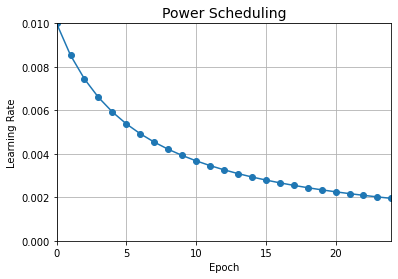

In [54]:
def listing4_6_1():
    import math

    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=0.0001)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )
    
    n_epochs = 15 # 25

    history = model.fit(
        X_train_scaled, 
        y_train, epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    
    HR()
        
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()

    learning_rate = 0.01
    decay = 0.0001 # 1e-4
    batch_size = 32
    n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
    epochs = np.arange(n_epochs)
    lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

    plt.plot(epochs, lrs,  "o-")
    plt.axis([0, n_epochs - 1, 0, 0.01])
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Power Scheduling", fontsize=14)
    plt.grid(True)
    plt.show()
    
listing4_6_1()

<a id='4.6.2'></a>
### 4.6.2 Exponential Scheduling
<a href="#top">[back to top]</a>

The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

<a id='4.6.2.1'></a>
#### 4.6.2.1 Exponential Scheduling - Standard
<a href="#top">[back to top]</a>

```lr = lr0 * 0.1**(epoch / s)```

----------------------------------------
157/157 - 0s - loss: 0.4602 - accuracy: 0.8822 - 300ms/epoch - 2ms/step
[test loss, test accuracy]: [0.4602213501930237, 0.8822000026702881]
----------------------------------------


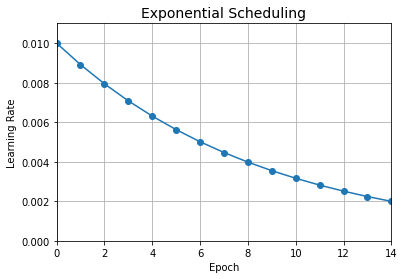

In [38]:
def listing4_6_2_1():
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    def exponential_decay(lr0, s):
        def exponential_decay_fn(epoch):
            return lr0 * 0.1**(epoch / s)
        return exponential_decay_fn

    exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 15 # 25
    
    lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,   
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[lr_scheduler],
        verbose=0
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    plt.plot(history.epoch, history.history["lr"], "o-")
    plt.axis([0, n_epochs - 1, 0, 0.011])
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Exponential Scheduling", fontsize=14)
    plt.grid(True)
    plt.show()
    
listing4_6_2_1()

<a id='4.6.2.2'></a>
#### 4.6.2.2 Exponential Scheduling - Using current LR
<a href="#top">[back to top]</a>

The schedule function can take the current learning rate as a second argument.

----------------------------------------
157/157 - 0s - loss: 0.3009 - accuracy: 0.9000 - 302ms/epoch - 2ms/step
[test loss, test accuracy]: [0.3008546829223633, 0.8999999761581421]
----------------------------------------


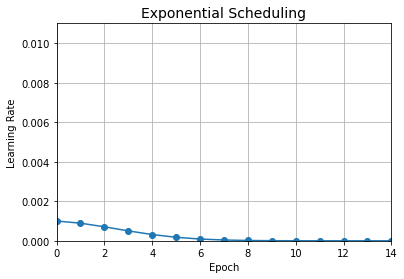

In [39]:
def listing4_6_2_2():
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    def exponential_decay(lr0, s):
        # The schedule function can take the current learning rate as a second argument.
        def exponential_decay_fn(epoch, lr0):
            return lr0 * 0.1**(epoch / s)
        return exponential_decay_fn

    exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 15 # 25
    
    lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,   
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[lr_scheduler],
        verbose=0
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    plt.plot(history.epoch, history.history["lr"], "o-")
    plt.axis([0, n_epochs - 1, 0, 0.011])
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Exponential Scheduling", fontsize=14)
    plt.grid(True)
    plt.show()
    
listing4_6_2_2()

<a id='4.6.2.3'></a>
#### 4.6.2.3 Exponential Scheduling - Update LR at each iteration
<a href="#top">[back to top]</a>

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

s: 25781
----------------------------------------
157/157 - 0s - loss: 0.4551 - accuracy: 0.8892 - 309ms/epoch - 2ms/step
[test loss, test accuracy]: [0.45512855052948, 0.88919997215271]
----------------------------------------


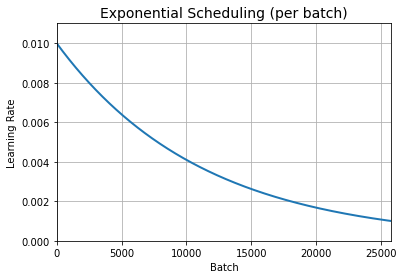

In [40]:
def listing4_6_2_3():
    tf.random.set_seed(42)
    
    K = keras.backend

    class ExponentialDecay(keras.callbacks.Callback):
        def __init__(self, s=40000):
            super().__init__()
            self.s = s

        def on_batch_begin(self, batch, logs=None):
            # Note: the `batch` argument is reset at each epoch
            lr = K.get_value(self.model.optimizer.learning_rate)
            K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
            
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    lr0 = 0.01
    optimizer = keras.optimizers.Nadam(learning_rate=lr0)
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )
    
    n_epochs = 15 # 25
    s = n_epochs * len(X_train) // 32 # number of steps in n_epochs (batch size = 32)
    
    print(f"s: {s}")

    exp_decay = ExponentialDecay(s)
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[exp_decay],
        verbose=0
    )
    
    HR()

    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
        
    n_steps = n_epochs * len(X_train) // 32
    steps = np.arange(n_steps)
    lrs = lr0 * 0.1**(steps / s)

    plt.plot(steps, lrs, "-", linewidth=2)
    plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
    plt.xlabel("Batch")
    plt.ylabel("Learning Rate")
    plt.title("Exponential Scheduling (per batch)", fontsize=14)
    plt.grid(True)
    plt.show()
    
listing4_6_2_3()

<a id='4.6.3'></a>
### 4.6.3 Piecewise Constant Scheduling
<a href="#top">[back to top]</a>

Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

----------------------------------------
157/157 - 0s - loss: 0.6636 - accuracy: 0.8386 - 305ms/epoch - 2ms/step
[test loss, test accuracy]: [0.6636028289794922, 0.8385999798774719]
----------------------------------------


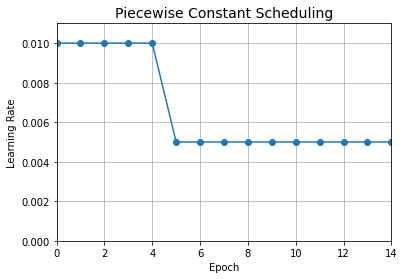

In [41]:
def listing4_6_3():
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    def piecewise_constant_fn(epoch):
        if epoch < 5:
            return 0.01
        elif epoch < 15:
            return 0.005
        else:
            return 0.001

    def piecewise_constant(boundaries, values):
        boundaries = np.array([0] + boundaries)
        values = np.array(values)
        def piecewise_constant_fn(epoch):
            return values[np.argmax(boundaries > epoch) - 1]
        return piecewise_constant_fn

    piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 15 # 25
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[lr_scheduler],
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
    plt.axis([0, n_epochs - 1, 0, 0.011])
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Piecewise Constant Scheduling", fontsize=14)
    plt.grid(True)
    plt.show()

listing4_6_3()

<a id='4.6.4'></a>
### 4.6.4 Performance Scheduling
<a href="#top">[back to top]</a>

Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

----------------------------------------
157/157 - 0s - loss: 0.5216 - accuracy: 0.8966 - 329ms/epoch - 2ms/step
[test loss, test accuracy]: [0.5216023325920105, 0.8966000080108643]
----------------------------------------


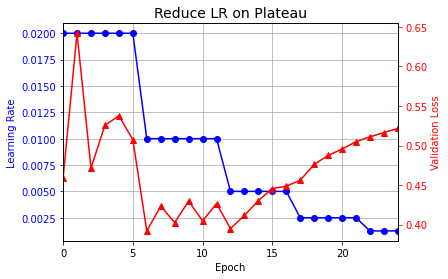

In [42]:
def listing4_6_4():
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
            
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )

    n_epochs = 25

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[lr_scheduler],
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    plt.plot(history.epoch, history.history["lr"], "bo-")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate", color='b')
    plt.tick_params('y', colors='b')
    plt.gca().set_xlim(0, n_epochs - 1)
    plt.grid(True)

    ax2 = plt.gca().twinx()
    ax2.plot(history.epoch, history.history["val_loss"], "r^-")
    ax2.set_ylabel('Validation Loss', color='r')
    ax2.tick_params('y', colors='r')

    plt.title("Reduce LR on Plateau", fontsize=14)
    plt.show()

listing4_6_4()

<a id='4.6.5'></a>
### 4.6.5 tf.keras schedulers
<a href="#top">[back to top]</a>

<a id='4.6.5.1'></a>
#### 4.6.5.1 tf.keras scheduler using ExponentialDecay
<a href="#top">[back to top]</a>

In [43]:
def listing4_6_5_1():

    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
    learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
    optimizer = keras.optimizers.SGD(learning_rate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )

    n_epochs = 15 # 25

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(history.history.keys())
    
listing4_6_5_1()

----------------------------------------
157/157 - 0s - loss: 0.3266 - accuracy: 0.8852 - 303ms/epoch - 2ms/step
[test loss, test accuracy]: [0.326625257730484, 0.885200023651123]
----------------------------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<a id='4.6.5.2'></a>
#### 4.6.5.2 tf.keras scheduler using PiecewiseConstantDecay
<a href="#top">[back to top]</a>

In [44]:
def listing4_6_5_2():
    import math
    
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
    
    
    # For piecewise constant scheduling
    batch_size = 32
    n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
    learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
        values=[0.01, 0.005, 0.001]
    )
    
    optimizer = keras.optimizers.SGD(learning_rate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )

    n_epochs = 15 # 25

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)
    HR()
    
    print(history.history.keys())
    
listing4_6_5_2()

----------------------------------------
157/157 - 0s - loss: 0.3239 - accuracy: 0.8844 - 287ms/epoch - 2ms/step
[test loss, test accuracy]: [0.32387539744377136, 0.8844000101089478]
----------------------------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<a id='4.6.6'></a>
### 4.6.6 1Cycle scheduling
<a href="#top">[back to top]</a>

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3862
----------------------------------------
----------------------------------------
157/157 - 0s - loss: 0.3174 - accuracy: 0.8932 - 309ms/epoch - 2ms/step
[test loss, test accuracy]: [0.31738173961639404, 0.8931999802589417]


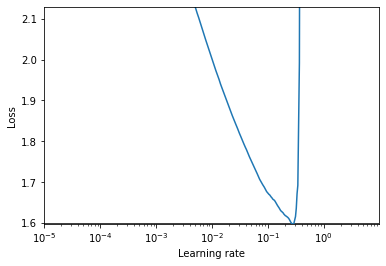

In [45]:
def listing4_6_6_1():
    import math
    
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
    
    K = keras.backend

    class ExponentialLearningRate(keras.callbacks.Callback):
        def __init__(self, factor):
            self.factor = factor
            self.rates = []
            self.losses = []
        def on_batch_end(self, batch, logs):
            self.rates.append(K.get_value(self.model.optimizer.learning_rate))
            self.losses.append(logs["loss"])
            K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

    def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
        init_weights = model.get_weights()
        iterations = math.ceil(len(X) / batch_size) * epochs
        factor = np.exp(np.log(max_rate / min_rate) / iterations)
        init_lr = K.get_value(model.optimizer.learning_rate)
        K.set_value(model.optimizer.learning_rate, min_rate)
        exp_lr = ExponentialLearningRate(factor)
        history = model.fit(
            X, 
            y, 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[exp_lr]
        )
        K.set_value(model.optimizer.learning_rate, init_lr)
        model.set_weights(init_weights)
        return exp_lr.rates, exp_lr.losses

    def plot_lr_vs_loss(rates, losses):
        plt.plot(rates, losses)
        plt.gca().set_xscale('log')
        plt.hlines(min(losses), min(rates), max(rates))
        plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    batch_size = 128
    rates, losses = find_learning_rate(
        model, 
        X_train_scaled, 
        y_train, 
        epochs=1, 
        batch_size=batch_size
    )

    HR()
    
    plot_lr_vs_loss(rates, losses)
    
    class OneCycleScheduler(keras.callbacks.Callback):
        def __init__(self, iterations, max_rate, start_rate=None,
                     last_iterations=None, last_rate=None):
            self.iterations = iterations
            self.max_rate = max_rate
            self.start_rate = start_rate or max_rate / 10
            self.last_iterations = last_iterations or iterations // 10 + 1
            self.half_iteration = (iterations - self.last_iterations) // 2
            self.last_rate = last_rate or self.start_rate / 1000
            self.iteration = 0
        def _interpolate(self, iter1, iter2, rate1, rate2):
            return ((rate2 - rate1) * (self.iteration - iter1)
                    / (iter2 - iter1) + rate1)
        def on_batch_begin(self, batch, logs):
            if self.iteration < self.half_iteration:
                rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            elif self.iteration < 2 * self.half_iteration:
                rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                         self.max_rate, self.start_rate)
            else:
                rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                         self.start_rate, self.last_rate)
            self.iteration += 1
            K.set_value(self.model.optimizer.learning_rate, rate)
    
    n_epochs = 25
    onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs, 
        batch_size=batch_size,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[onecycle],
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)

listing4_6_6_1()

---
<a name='5.0'></a>
# 5. Avoiding Overfitting Through Regularization / 正則化による過学習の防止
<a href="#top">[back to top]</a>

We already implemented one of the best regularization techniques in Chapter 10: early stopping. Moreover, even though Batch Normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In this section we will examine other popular regularization techniques for neural networks: l1 and l2 regularization, dropout, and max-norm regularization.

<a name='5.1'></a>
## 5.1 $\ell_1$ and $\ell_2$ regularization / ℓ1、ℓ2 正則化
<a href="#top">[back to top]</a>

In [46]:
def listing5_1():
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            300, activation="elu",
            kernel_initializer="he_normal",
            kernel_regularizer=keras.regularizers.l2(0.01)
            # or l1(0.1) for ℓ1 regularization with a factor of 0.1
            # or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, 
            #    with factors 0.1 and 0.01 respectively
        ),
        keras.layers.Dense(
            100, activation="elu",
            kernel_initializer="he_normal",
            kernel_regularizer=keras.regularizers.l2(0.01)
        ),
        keras.layers.Dense(
            10, activation="softmax",
            kernel_regularizer=keras.regularizers.l2(0.01)
        )
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 15
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)    
    
listing5_1()

----------------------------------------
157/157 - 0s - loss: 0.6615 - accuracy: 0.8480 - 314ms/epoch - 2ms/step
[test loss, test accuracy]: [0.6614769101142883, 0.8479999899864197]


<a name='5.1.1'></a>
### 5.1.1 $\ell_1$ and $\ell_2$ regularization using functools.partial()
<a href="#top">[back to top]</a>

In [47]:
def listing5_1_1():
    from functools import partial
    
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    RegularizedDense = partial(
        keras.layers.Dense,
        activation="elu",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(0.01)
    )

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(300),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 2

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)    
    
listing5_1_1()

----------------------------------------
157/157 - 0s - loss: 0.6828 - accuracy: 0.8382 - 316ms/epoch - 2ms/step
[test loss, test accuracy]: [0.6828034520149231, 0.8381999731063843]


<a id='5.2'></a>
## 5.2 Dropout / ドロップアウト
<a href="#top">[back to top]</a>

Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

Many state-of-the-art architectures only use dropout after the last hidden layer.

Dropout rate guideline:

* 10-20% for normal networks
* 20–30% in recurrent neural nets
* 40–50% in convolutional neural networks

In [48]:
def listing5_2():
    
    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )

    n_epochs = 25

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    
    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    print("[test loss, test accuracy]:", eval_result)   

listing5_2()

----------------------------------------
157/157 - 0s - loss: 0.3026 - accuracy: 0.8942 - 299ms/epoch - 2ms/step
[test loss, test accuracy]: [0.30263271927833557, 0.8942000269889832]


<a id='5.3'></a>
## 5.3 Alpha Dropout
<a href="#top">[back to top]</a>

If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use alpha dropout: this is a variant of dropout that preserves the mean and standard deviation of its inputs (it was introduced in the same paper as SELU, as regular dropout would break self-normalization).

In [49]:
def listing5_3():

    tf.random.set_seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True
    )

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )

    model.summary()
    
    n_epochs = 20

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    HR()
    
    eval_result = model.evaluate(X_test_scaled, y_test, verbose=2)
    print("Run 1: [test loss, test accuracy]:", eval_result)   
    HR()
    
    eval_result = model.evaluate(X_train_scaled, y_train, verbose=2)
    print("Run 2: [test loss, test accuracy]:", eval_result) 
    
listing5_3()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 alpha_dropout (AlphaDropout  (None, 784)              0         
 )                                                               
                                                                 
 dense_278 (Dense)           (None, 300)               235500    
                                                                 
 alpha_dropout_1 (AlphaDropo  (None, 300)              0         
 ut)                                                             
                                                                 
 dense_279 (Dense)           (None, 100)               30100     
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 100)            

<a id='5.4'></a>
## 5.4 Monte Carlo (MC) Dropout / モンテカルロ（MC）ドロップアウト
<a href="#top">[back to top]</a>

Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off.

<a id='5.4.1'></a>
### 5.4.1 MC Dropout, Model with standard layers
<a href="#top">[back to top]</a>

Here we force training mode, since the model layers do not behave in a special way during training (such as `BatchNormalization` layers)

In [50]:
def listing5_4_1():
    
    tf.random.set_seed(42)
    np.random.seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    # Use regular Dropout layer here
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True
    )

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )
    
    n_epochs = 2 # 20

    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    
    eval_result = model.evaluate(X_test_scaled, y_test, verbose=0)
    print("Eval 1: [test loss, test accuracy]:", eval_result)   
    HR()
    
    eval_result = model.evaluate(X_train_scaled, y_train, verbose=0)
    print("Eval 2: [test loss, test accuracy]:", eval_result) 
    HR()

    # Boost the dropout model we trained earlier without retraining it:
    # We just make 100 predictions over the test set, 
    # setting to training=true ensure that the layer is active, 
    # and stack the predictions.
    # Since dropout is active, all the predictions will be different
    MC_samples_num = 100
    
    print(f"""The number of Monte Carlo samples you use ({MC_samples_num} in this example) is a hyperparameter you can tweak. 
The higher it is, the more accurate the predictions and their uncertainty estimates will be.
However, inference time is accordingly increased.""")
    HR()
    
    y_probas = np.stack(
        [model(X_test_scaled, training=True) for sample in range(MC_samples_num)]
    )
    print(f"shape of y_probas: {y_probas.shape}")
    HR()
    
    # Average over the first dimension via axis=0,
    # then get an array of shape [10000, 10], like we would 
    # get with a single prediction.
    y_proba = y_probas.mean(axis=0)
    print(f"shape of y_proba: {y_proba.shape}")
    HR()
    
    y_std = y_probas.std(axis=0)

    print("Model's prediction for the first instance in the test set, with dropout off:")
    print(np.round(model.predict(X_test_scaled[:1]), 2))
    HR()

    print("Model's prediction for first few instances, with dropout activated:")
    print(np.round(y_probas[:, :1], 2)[:5][:])
    HR()

    print("Average over the first dimension, to get the following MC Dropout predictions:")
    print(np.round(y_proba[:1], 2))
    HR()
    
    y_std = y_probas.std(axis=0)
    print("Standard deviation of the probability estimates:")
    print(np.round(y_std[:1], 2))
    HR()

    y_pred = np.argmax(y_proba, axis=1)

    accuracy = np.sum(y_pred == y_test) / len(y_test)
    print(f"Model accuracy: {accuracy}")
    
listing5_4_1()

Eval 1: [test loss, test accuracy]: [0.4643721580505371, 0.8431000113487244]
----------------------------------------
Eval 2: [test loss, test accuracy]: [0.39823269844055176, 0.8605272769927979]
----------------------------------------
The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. 
The higher it is, the more accurate the predictions and their uncertainty estimates will be.
However, inference time is accordingly increased.
----------------------------------------
shape of y_probas: (100, 10000, 10)
----------------------------------------
shape of y_proba: (10000, 10)
----------------------------------------
Model's prediction for the first instance in the test set, with dropout off:
[[0.   0.   0.   0.   0.   0.03 0.   0.14 0.   0.83]]
----------------------------------------
Model's prediction for first few instances, with dropout activated:
[[[0.   0.   0.   0.   0.   0.05 0.   0.43 0.   0.52]]

 [[0.   0.   0.   0.   0.   0.01 0.

<a id='5.4.2'></a>
### 5.4.2 MC Dropout, Model with customized layers
<a href="#top">[back to top]</a>

If you have a model that was already trained using `Dropout` or `AlphaDropout`, you need to create a new model that’s identical to the existing model except that it replaces the layers with `MCDropout`, then copy the existing model's weights to your new model.

In [51]:
def listing5_4_2():
    
    tf.random.set_seed(42)
    np.random.seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    class MCDropout(keras.layers.Dropout):
        def call(self, inputs):
            return super().call(inputs, training=True)

    class MCAlphaDropout(keras.layers.AlphaDropout):
        def call(self, inputs):
            return super().call(inputs, training=True)
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        #keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True
    )
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )
    
    n_epochs = 3
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )
    
    HR()
    
    model.summary()
    
    print("Check for AlphaDropout or Dropout layers to replace:")
    for layer in model.layers:
        print(isinstance(layer, keras.layers.AlphaDropout) or isinstance(layer, keras.layers.Dropout), layer)
        
    HR()
      
    new_model = []
    for layer in model.layers:
        if isinstance(layer, keras.layers.AlphaDropout):
            new_model.append(MCAlphaDropout(layer.rate))
        elif isinstance(layer, keras.layers.Dropout):
            new_model.append(MCDropout(layer.rate))
        else:
            new_model.append(layer)
            
    mc_model = keras.models.Sequential(new_model)
            
    mc_model.summary()
    
    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True
    )
    
    mc_model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )

    mc_model.set_weights(model.get_weights())
    
    MC_samples_num = 100
    
    # Now we can use the model with MC Dropout:
    print("Model's prediction for the first instance in the test set, with dropout off:")
    result_mc = np.round(
        np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(MC_samples_num)], axis=0), 2
    )
    print(f"result_mc: {result_mc}")
    
listing5_4_2()

----------------------------------------
157/157 - 0s - loss: 0.4528 - accuracy: 0.8486 - 295ms/epoch - 2ms/step
----------------------------------------
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 alpha_dropout_3 (AlphaDropo  (None, 784)              0         
 ut)                                                             
                                                                 
 dense_284 (Dense)           (None, 300)               235500    
                                                                 
 alpha_dropout_4 (AlphaDropo  (None, 300)              0         
 ut)                                                             
                                                                 
 dense_285 (Dense)           (N

<a id='5.4.3'></a>
### 5.4.3 Creating a model from scratch with MC Dropout layer
<a href="#top">[back to top]</a>

In [52]:
def listing5_4_3():
    
    tf.random.set_seed(42)
    np.random.seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    class MCDropout(keras.layers.Dropout):
        def call(self, inputs):
            return super().call(inputs, training=True)

    class MCAlphaDropout(keras.layers.AlphaDropout):
        def call(self, inputs):
            return super().call(inputs, training=True)
    
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        MCDropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        MCDropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        MCDropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True
    )
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"]
    )
    
    n_epochs = 3
    
    model.summary()
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=0
    )
    
    eval_result = model.evaluate (
        X_valid_scaled, 
        y_valid,
        verbose=2
    )

    HR()
    
    # How to best calculate the prediction now?
    
    MC_samples_num = 100
    
    # Now we can use the model with MC Dropout:
    print("Model's prediction for the first instance in the test set, with dropout off:")
    result_mc = np.round(
        np.mean([model.predict(X_test_scaled[:1]) for sample in range(MC_samples_num)], axis=0), 2
    )
    print(f"result_mc: {result_mc}")
    
listing5_4_3()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout_1 (MCDropout)    (None, 784)               0         
                                                                 
 dense_287 (Dense)           (None, 300)               235500    
                                                                 
 mc_dropout_2 (MCDropout)    (None, 300)               0         
                                                                 
 dense_288 (Dense)           (None, 100)               30100     
                                                                 
 mc_dropout_3 (MCDropout)    (None, 100)               0         
                                                                 
 dense_289 (Dense)           (None, 10)              

<a id='5.5'></a>
## 5.5 Max-Norm Regularization / 重み上限正則化
<a href="#top">[back to top]</a>

MaxNorm weight constraint.

Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.

Also available via the shortcut function tf.keras.constraints.max_norm

https://www.tensorflow.org/api_docs/python/tf/keras/constraints/MaxNorm

In [53]:
def listing5_5():
    from functools import partial
    
    tf.random.set_seed(42)
    np.random.seed(42)
    
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

    pixel_means = X_train.mean(axis=0, keepdims=True)
    pixel_stds = X_train.std(axis=0, keepdims=True)
    X_train_scaled = (X_train - pixel_means) / pixel_stds
    X_valid_scaled = (X_valid - pixel_means) / pixel_stds
    X_test_scaled = (X_test - pixel_means) / pixel_stds
        
    MaxNormDense = partial(
        keras.layers.Dense,
        activation="selu", 
        kernel_initializer="lecun_normal",
        kernel_constraint=keras.constraints.max_norm(1.)
    )

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(300),
        MaxNormDense(100),
        keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="nadam", 
        metrics=["accuracy"]
    )
    
    n_epochs = 5
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=n_epochs,
        validation_data=(X_valid_scaled, y_valid),
        verbose=2
    )

    HR()
    
    eval_result = model.evaluate (
        X_valid_scaled,
        y_valid,
        verbose=2
    )

    print("[test loss, test accuracy]:", eval_result)
    
    HR()
    
    print(model.summary())    

listing5_5()

Epoch 1/5
1719/1719 - 7s - loss: 0.4744 - accuracy: 0.8330 - val_loss: 0.3735 - val_accuracy: 0.8620 - 7s/epoch - 4ms/step
Epoch 2/5
1719/1719 - 7s - loss: 0.3542 - accuracy: 0.8713 - val_loss: 0.3677 - val_accuracy: 0.8658 - 7s/epoch - 4ms/step
Epoch 3/5
1719/1719 - 6s - loss: 0.3270 - accuracy: 0.8783 - val_loss: 0.3510 - val_accuracy: 0.8700 - 6s/epoch - 3ms/step
Epoch 4/5
1719/1719 - 6s - loss: 0.3180 - accuracy: 0.8821 - val_loss: 0.3469 - val_accuracy: 0.8720 - 6s/epoch - 3ms/step
Epoch 5/5
1719/1719 - 6s - loss: 0.3116 - accuracy: 0.8833 - val_loss: 0.3247 - val_accuracy: 0.8804 - 6s/epoch - 3ms/step
----------------------------------------
157/157 - 0s - loss: 0.3247 - accuracy: 0.8804 - 311ms/epoch - 2ms/step
[test loss, test accuracy]: [0.3247053921222687, 0.8804000020027161]
----------------------------------------
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatte